# Synthetic Tree with Fixed Branch b=3

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
type = "fixed"
final_level = 8

In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import tqdm as tqdm
from IPython.display import clear_output

# Dense dataset

## Load the data

In [4]:
from data_structure import GeoSpine
from data_structure import OD_tree

folder_path = f"../data/synthetic_{type}_branching_nozero/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

spine = GeoSpine(geo_spine)
Tree_dense = OD_tree(df, spine)

## Histogram of counts for the finest level

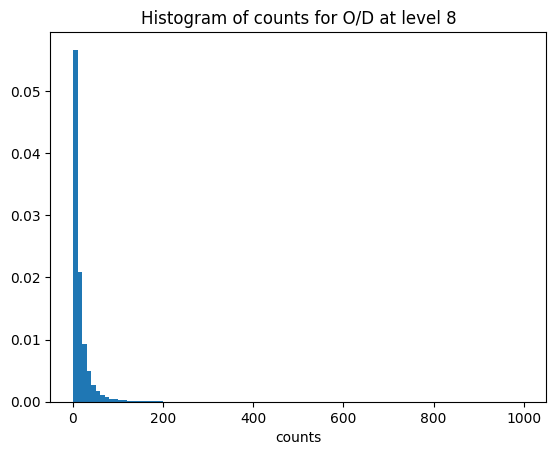

In [5]:
# make historga of count
import matplotlib.pyplot as plt

final_level = Tree_dense.depth
geo_level = int(final_level / 2)
data_true = Tree_dense.get_data_at_level(Tree_dense.depth)
plt.hist(data_true["COUNT"], bins=100, density=True)
plt.title(f"Histogram of counts for O/D at level {geo_level}")
plt.xlabel("counts")
plt.show()

In [6]:
print("Sparsity of the data ", 1 - len(data_true) / (len(Tree_dense.spine.get_nodes(level=geo_level)) ** 2))

Sparsity of the data  0.0


# Mechanism

In [7]:
import argparse

epsilons = [1., 10.]
delta = 1E-8
num_experiments = 1
levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(geo_level + 1) for j in range(i, i + 2) if
                       j < geo_level + 1]

# mechanisms, epsilons, experiments, levels
num_mechanisms = 3
max_error_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate_dense = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="greedy_integer", p='inf', integer_true=False, split_method='uniform')

## Apply Stability Histogram

In [22]:
from mechanism import VanillaSH
from metrics import analysis

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    # for collecting error distribution for multiple experiments
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillash_dense = VanillaSH(Tree_dense, args)
        # for collecting error distribution for multiple levels
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillash_dense,
                                     spine=Tree_dense.spine,
                                     workload=workload)
            max_error_dense[0, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_dense[0, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_dense[0, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[0, e] = error_to_add
    std[0, e] = std_to_add

Experiment 1
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 1.83 seconds


100%|██████████| 17/17 [00:03<00:00,  5.33it/s]


## Apply VanillaGauss

In [23]:
from mechanism import VanillaGauss

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillagauss = VanillaGauss(Tree_dense, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillagauss,
                                     spine=Tree_dense.spine,
                                     workload=workload)
            max_error_dense[1, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_dense[1, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_dense[1, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[1, e] = error_to_add
    std[1, e] = std_to_add

Experiment 1
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 1.76 seconds


100%|██████████| 17/17 [00:07<00:00,  2.34it/s]


## Apply GaussOpt

In [42]:
from mechanism import GaussOpt
import time

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="int_opt", p='inf', split_method='uniform')

epsilons = [0.01, 0.1, 1, 10]
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_gaussopt = GaussOpt(Tree_dense, args)
        absolute_error_distribution = []
    #     for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
    #         workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
    #         analysis_dict = analysis(data_true=data_true,
    #                                  dp_data=data_gaussopt,
    #                                  spine=Tree_dense.spine,
    #                                  workload=workload)
    #         max_error_dense[2, e, i, j] = analysis_dict["max_absolute_error"]
    #         false_discovery_rate_dense[2, e, i, j] = analysis_dict["false_discovery_rate"]
    #         false_negative_rate_dense[2, e, i, j] = analysis_dict["false_negative_rate"]
    #         absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
    #     absolute_error_distribution_epsilon.append(absolute_error_distribution)
    #     # clear jupyter output on the terminal
    #     clear_output(wait=True)
    # # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    # error_to_add = np.zeros(len(levels))
    # std_to_add = np.zeros(len(levels))
    # for j in range(len(levels)):
    #     concantenation = []
    #     # concatenate the list of lists
    #     for i in range(num_experiments):
    #         concantenation.append(absolute_error_distribution_epsilon[i][j])
    #     # assert they are all the same length
    #     assert len(set([len(x) for x in concantenation])) == 1
    #     # flatten the list
    #     error_to_add[j] = np.mean(np.concatenate(concantenation))
    #     std_to_add[j] = np.std(np.concatenate(concantenation))
    # MAE[2, e] = error_to_add
    # std[2, e] = std_to_add

Experiment 1
Optimizing level 1/16...
Optimizing level 2/16...
Optimizing level 3/16...
Optimizing level 4/16...
Optimizing level 5/16...
Optimizing level 6/16...
Optimizing level 7/16...
Optimizing level 8/16...
Optimizing level 9/16...
Optimizing level 10/16...
Optimizing level 11/16...
Optimizing level 12/16...
Optimizing level 13/16...
Optimizing level 14/16...
Optimizing level 15/16...


KeyboardInterrupt: 

 ## Maximum Absolute Error per Level

In [11]:
mechanisms = ["VanillaSH", "VanillaGauss", "GaussOpt"]
markers = [["-s", "-*", "-o"], ["--s", "--*", "--o"]]
colors = ["blue", "orange", "green"]
density = "dense"

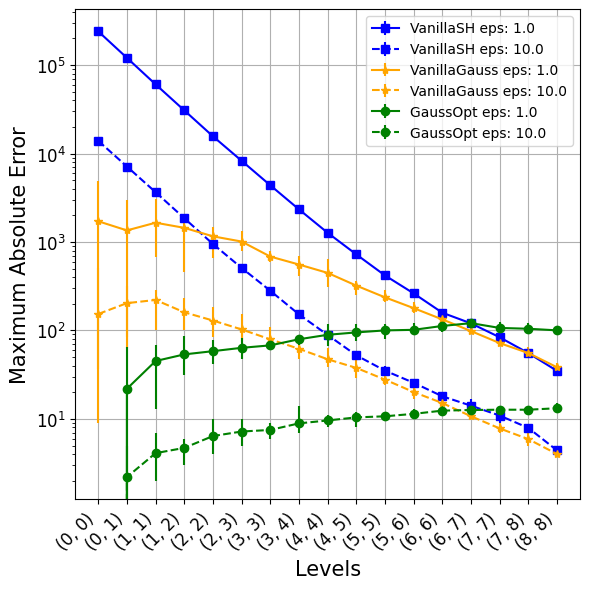

In [12]:
# plot line
import matplotlib.pyplot as plt

array = max_error_dense
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Maximum Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
# save a version with no legend
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/max_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/max_error.pdf", dpi=300)
plt.show()

## Mean Absolute Error per Level

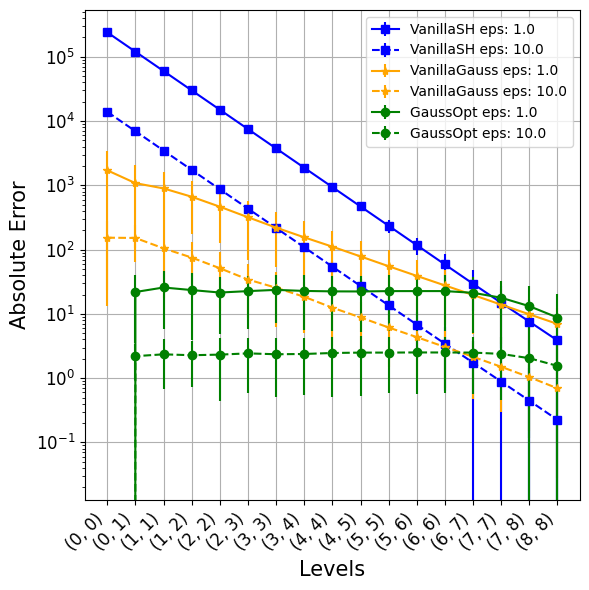

In [13]:
# plot line
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        ax.errorbar(range(len(levels)), MAE[i, j], yerr=std[i, j],
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
# save a version with no legend
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/mean_absolute_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/mean_absolute_error.pdf", dpi=300)
plt.show()

## False Discovery Rate

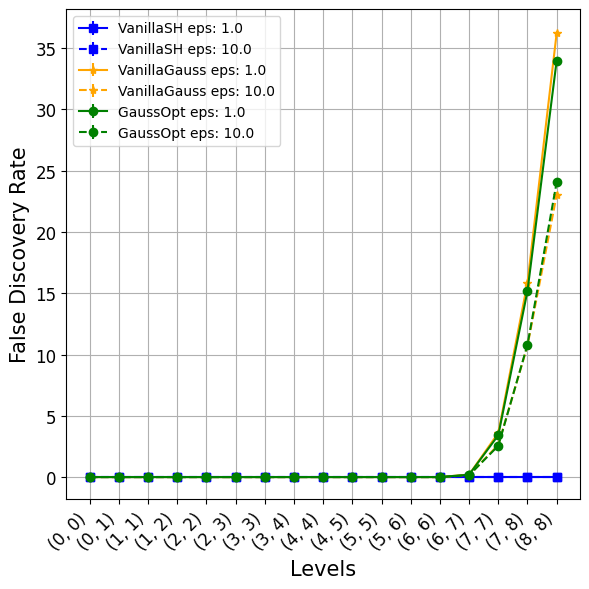

In [14]:
# plot line
import matplotlib.pyplot as plt

array = false_discovery_rate_dense
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Discovery Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_discovery_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_discovery_rate.pdf", dpi=300)
plt.show()

## False Negative Rate

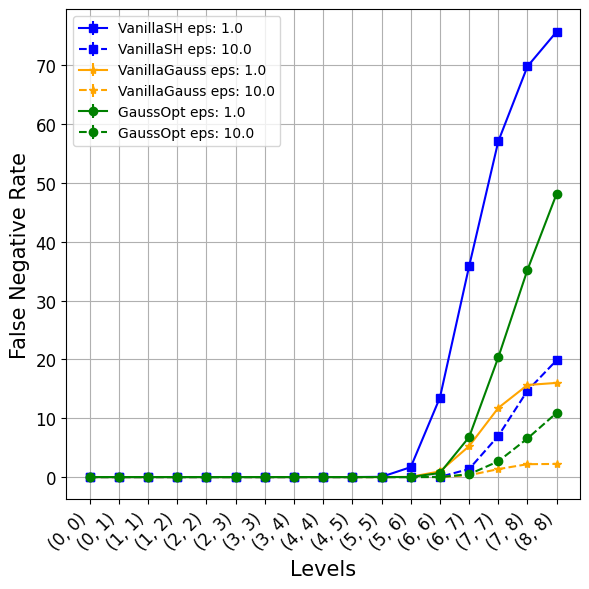

In [15]:
# plot line
import matplotlib.pyplot as plt

array = false_negative_rate_dense
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Negative Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_negative_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()

# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_negative_rate.pdf", dpi=300)
plt.show()

# Sparse dataset

## Load the data

In [43]:
density = "sparse"

In [44]:
from data_structure import GeoSpine
from data_structure import OD_tree

folder_path = f"../data/synthetic_{type}_branching_{density}/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

final_level = 8
spine = GeoSpine(geo_spine)
Tree_sparse = OD_tree(df, spine)

## Histogram of counts for the finest level

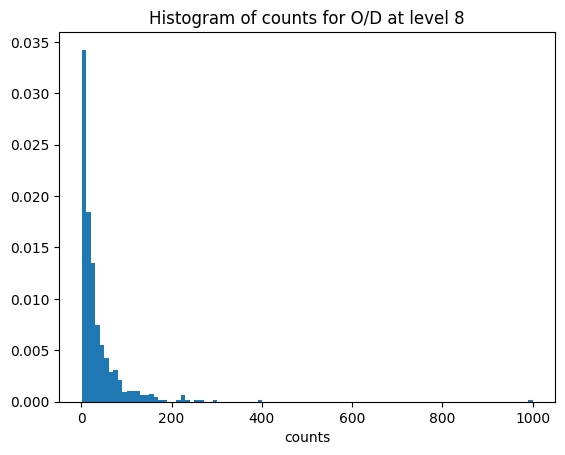

In [45]:
# make historga of count
import matplotlib.pyplot as plt

final_level = Tree_sparse.depth
geo_level = int(final_level / 2)
data_true = Tree_sparse.get_data_at_level(Tree_sparse.depth)
plt.hist(data_true["COUNT"], bins=100, density=True)
plt.title(f"Histogram of counts for O/D at level {geo_level}")
plt.xlabel("counts")
plt.show()

In [46]:
print("Sparsity of the data ", 1 - len(data_true) / (len(Tree_sparse.spine.get_nodes(level=geo_level)) ** 2))

Sparsity of the data  0.9900054931640625


# Mechanism

In [47]:
import argparse

epsilons = [1., 10.]
delta = 1E-8
num_experiments = 1
levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(geo_level + 1) for j in range(i, i + 2) if
                       j < geo_level + 1]

# mechanisms, epsilons, experiments, levels
num_mechanisms = 3
max_error_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="greedy_integer",
                          p='inf', integer_true=False, split_method='uniform')

## Apply Stability Histogram

In [31]:
from mechanism import VanillaSH
from metrics import analysis

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillash_sparse = VanillaSH(Tree_sparse, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillash_sparse,
                                     spine=Tree_sparse.spine,
                                     workload=workload)
            max_error_sparse[0, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[0, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[0, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[0, e] = error_to_add
    std[0, e] = std_to_add

Experiment 1
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 0.96 seconds


100%|██████████| 17/17 [00:00<00:00, 48.47it/s]


## Apply VanillaGauss

In [32]:
from mechanism import VanillaGauss

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillagauss_sparse = VanillaGauss(Tree_sparse, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillagauss_sparse,
                                     spine=Tree_sparse.spine,
                                     workload=workload)
            max_error_sparse[1, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[1, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[1, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[1, e] = error_to_add
    std[1, e] = std_to_add

Experiment 1
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 1.86 seconds


100%|██████████| 17/17 [00:04<00:00,  4.14it/s]


## Apply GaussOpt

In [49]:
from mechanism import GaussOpt
import time
from metrics import analysis

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=False,
                          optimizer="int_opt", p='inf', split_method='uniform')

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        start = time.time()
        data_gaussopt_sparse = GaussOpt(Tree_sparse, args)
        print(f"Time to compute {time.time() - start}")
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_gaussopt_sparse,
                                     spine=Tree_sparse.spine,
                                     workload=workload)
            max_error_sparse[2, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[2, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[2, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[2, e] = error_to_add
    std[2, e] = std_to_add

Experiment 1
Optimizing level 1/16...
Optimizing level 2/16...
Optimizing level 3/16...
Optimizing level 4/16...
Optimizing level 5/16...
Optimizing level 6/16...
Optimizing level 7/16...
Optimizing level 8/16...
Optimizing level 9/16...
Optimizing level 10/16...
Optimizing level 11/16...
Optimizing level 12/16...
Optimizing level 13/16...
Optimizing level 14/16...
Optimizing level 15/16...
Optimizing level 16/16...
Time taken to create the dataset: 11.57 seconds
Done!
Time to compute 11.570353031158447


100%|██████████| 17/17 [00:00<00:00, 31.23it/s]


## Maximum Absolute Error per Level

In [50]:
mechanisms = ["VanillaSH", "VanillaGauss", "GaussOpt"]
markers = [["-s", "-*", "-o"], ["--s", "--*", "--o"]]
colors = ["blue", "orange", "green"]
density = "sparse"

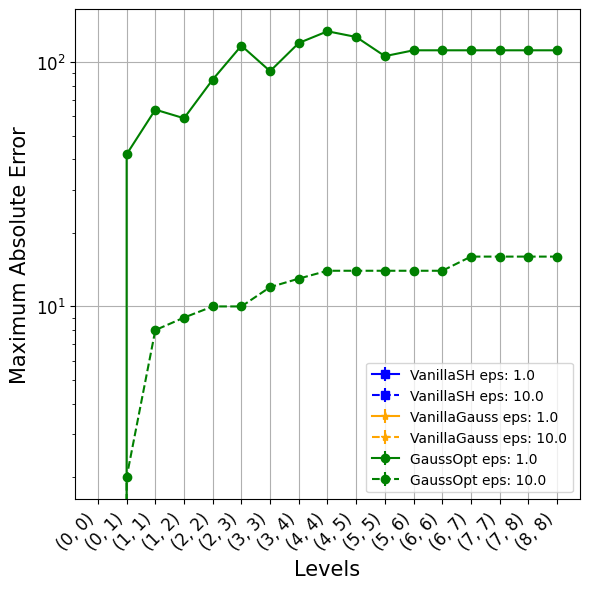

In [51]:
# plot line
import matplotlib.pyplot as plt

array = max_error_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Maximum Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/max_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/max_error.pdf", dpi=300)
plt.show()

## Mean Absolute Error per Level

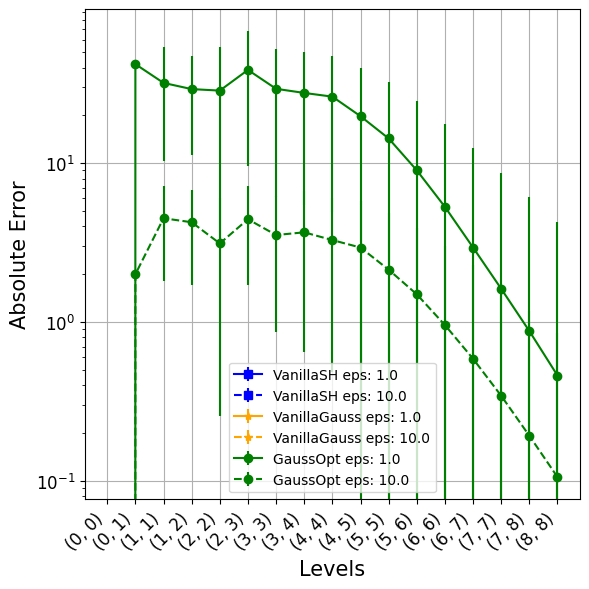

In [52]:
# plot line
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        ax.errorbar(range(len(levels)), MAE[i, j], yerr=std[i, j],
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/mean_absolute_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/mean_absolute_error.pdf", dpi=300)
plt.show()

## False Discovery Rate

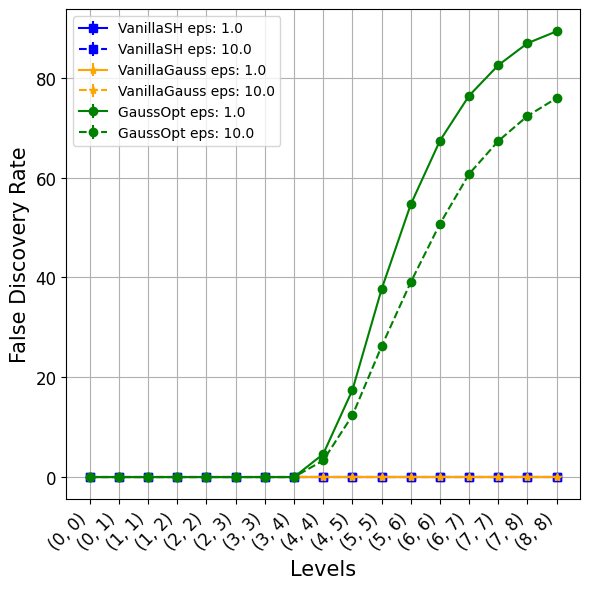

In [53]:
# plot line
import matplotlib.pyplot as plt

array = false_discovery_rate_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        error = np.abs(error)
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Discovery Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_discovery_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_discovery_rate.pdf", dpi=300)
plt.show()

## False Negative Rate

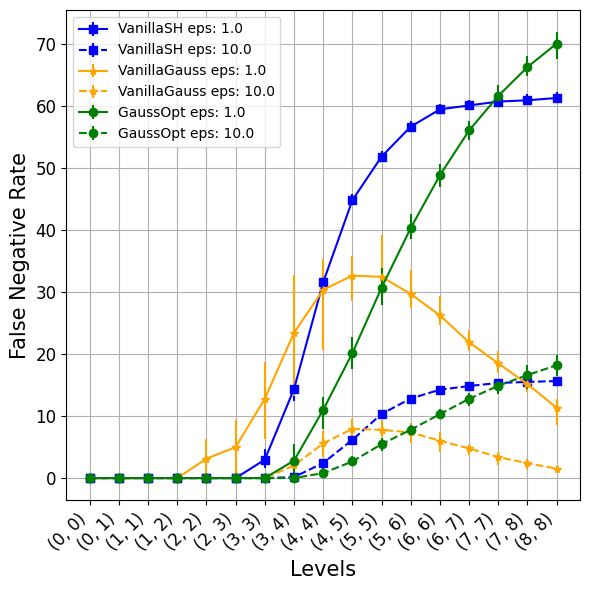

In [28]:
# plot line
import matplotlib.pyplot as plt

array = false_negative_rate_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Negative Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
# save
plt.tight_layout()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_negative_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
plt.savefig(f"../plots/synthetic_data_{type}_branch_{density}/false_negative_rate.pdf", dpi=300)
plt.show()